## Sensitivity Analysis using PRCC

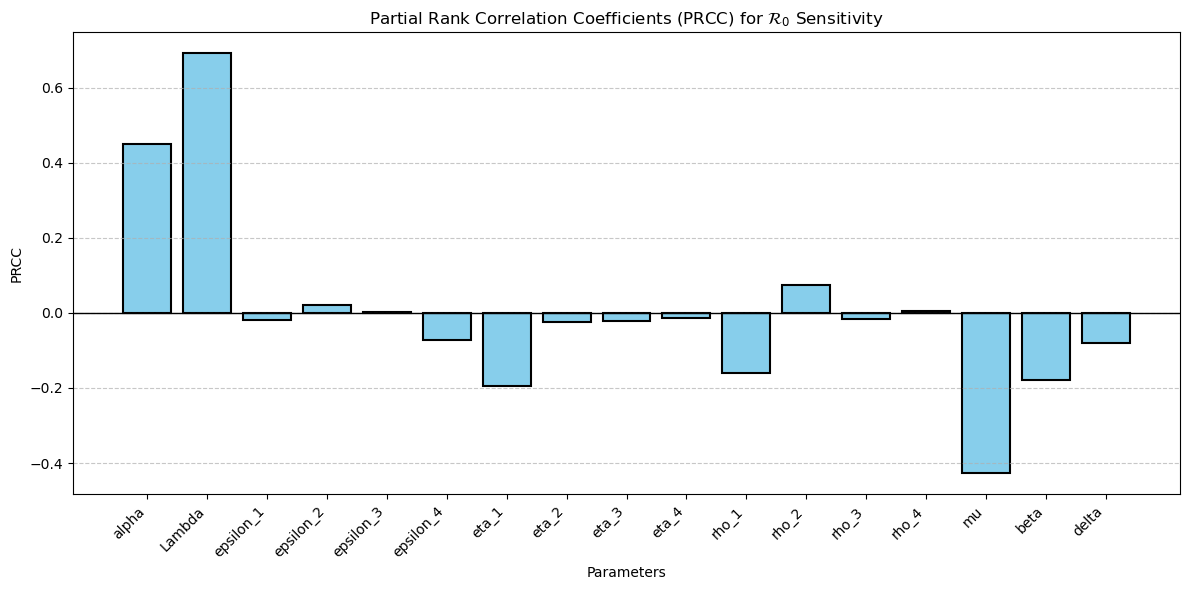

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
from scipy.integrate import odeint
import pandas as pd

# Step 1: Define the parameters and their ranges
parameter_names = [
    'alpha', 'Lambda', 'epsilon_1', 'epsilon_2', 'epsilon_3', 'epsilon_4',
    'eta_1', 'eta_2', 'eta_3', 'eta_4', 'rho_1', 'rho_2', 'rho_3', 'rho_4', 
    'mu', 'beta', 'delta'
]

# Ranges for each parameter (can be adjusted as needed)
parameter_ranges = {
    'alpha': [0.08, 0.09],
    'Lambda': [0.025, 0.03],
    'epsilon_1': [0.009, 0.011],
    'epsilon_2': [0.004, 0.006],
    'epsilon_3': [0.0002, 0.0004],
    'epsilon_4': [0.00005, 0.00015],
    'eta_1': [0.28, 0.32],
    'eta_2': [0.38, 0.42],
    'eta_3': [0.46, 0.54],
    'eta_4': [0.75, 0.84],
    'rho_1': [0.028, 0.032],
    'rho_2': [0.018, 0.022],
    'rho_3': [0.014, 0.016],
    'rho_4': [0.0045, 0.0055],
    'mu': [0.014, 0.016],
    'beta': [0.065, 0.07],
    'delta': [0.029, 0.032]
}

# Step 2: Generate random samples for each parameter
num_samples = 1000  # Number of samples for each parameter

parameter_samples = {name: np.random.uniform(low, high, num_samples) for name, (low, high) in parameter_ranges.items()}

# Step 3: Define the formula for R0
def calculate_R0(params):
    alpha = params['alpha']
    Lambda = params['Lambda']
    epsilon = np.array([params[f'epsilon_{i}'] for i in range(1, 5)])
    eta = np.array([params[f'eta_{i}'] for i in range(1, 5)])
    rho = np.array([params[f'rho_{i}'] for i in range(1, 5)])
    mu = params['mu']
    beta = params['beta']
    delta = params['delta']
    
    V_star = np.zeros(4)
    V_star[0] = eta[0] * rho[0] * (Lambda + epsilon.sum()) / (mu + epsilon[0] + eta[1] * rho[1])
    V_star[1] = eta[1] * rho[1] * V_star[0] / (mu + epsilon[1] + eta[2] * rho[2])
    V_star[2] = eta[2] * rho[2] * V_star[1] / (mu + epsilon[2] + eta[3] * rho[3])
    V_star[3] = eta[3] * rho[3] * V_star[2] / (mu + epsilon[3])
    
    S_star = (Lambda + epsilon @ V_star) / (mu + eta[0] * rho[0])
    
    R0 = alpha * (Lambda + epsilon @ V_star) / ((mu + eta[0] * rho[0]) * (beta + delta + mu))
    
    return R0

# Step 4: Calculate R0 for each sample set
R0_values = []
for i in range(num_samples):
    params = {name: parameter_samples[name][i] for name in parameter_names}
    R0_values.append(calculate_R0(params))

R0_values = np.array(R0_values)

# Step 5: Compute PRCC values
prcc_values = {}
for param in parameter_names:
    prcc, _ = spearmanr(parameter_samples[param], R0_values)
    prcc_values[param] = prcc

# Step 6: Plot PRCC values
plt.figure(figsize=(12, 6))
bars = plt.bar(prcc_values.keys(), prcc_values.values(), color='skyblue', edgecolor='black', linewidth=1.5)
plt.axhline(0, color='black', linewidth=1)
plt.xlabel('Parameters')
plt.ylabel('PRCC')
plt.title('Partial Rank Correlation Coefficients (PRCC) for $\mathcal{R}_0$ Sensitivity')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

## Numerical Simulations with actual and estimated values

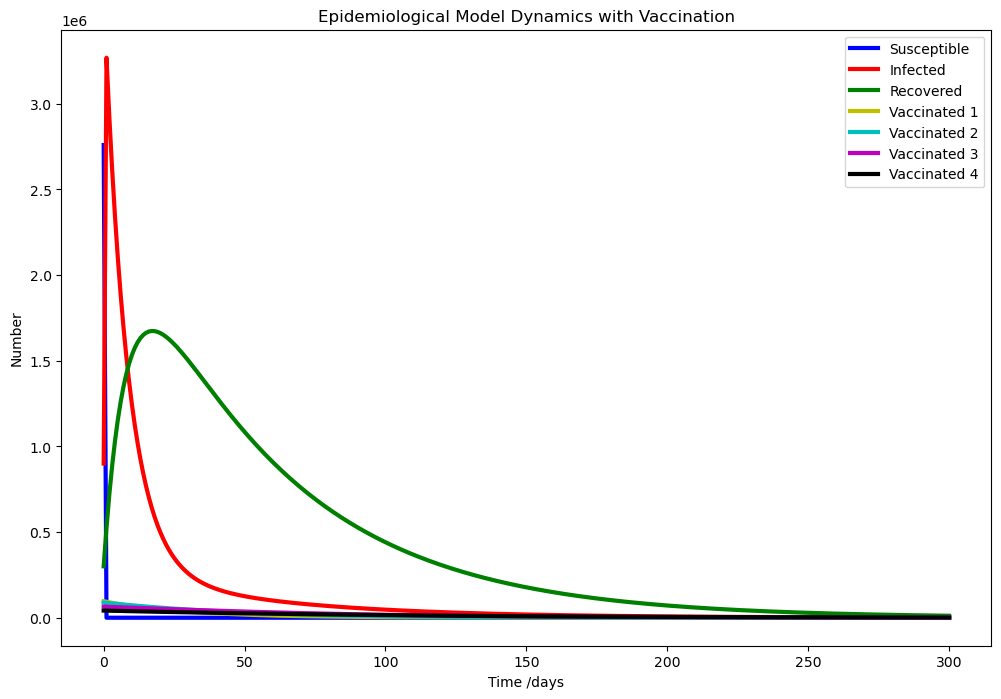

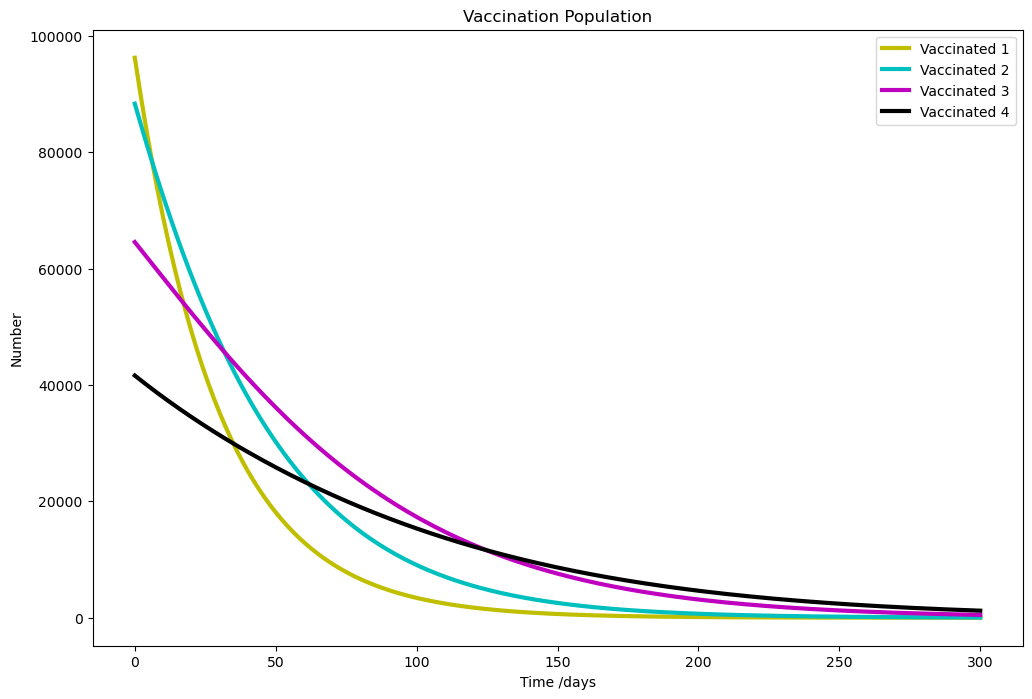

In [2]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# Initial conditions (from the literature)
N = 4250000
S = N - 900000 - 300000 - 88348 - 96245 - 64559 - 41625 # everyone starts out as susceptible
I = 900000   # initially infected
R = 300000    # initially recovered
V1 = 96245    # initially vaccinated (first dose)
V2 = 88348    # initially vaccinated (second dose)
V3 = 64559    # initially vaccinated (third dose)
V4 = 41625    # initially vaccinated (fourth dose)

# Total population size
#N = S + I + R + V1 + V2 + V3 + V4

# A grid of time points (in days)
t = np.linspace(0, 300,300)  # from day 0 to day 100, generate 50 points

Lambda = 0.0277  # Example value for lambda
alpha = 0.086
beta = 0.067841  # Example value for beta
mu = 0.0154  # Example value for mu
gamma = 0.01  # Example value for gamma
delta = 0.0308  # Example value for delta

# Adjusted values for rho (vaccination rates)
rho1 = 0.03 
rho2 = 0.02
rho3 = 0.015
rho4 = 0.005

eta1=0.3
eta2=0.4
eta3=0.5
eta4=0.8

# Adjusted values for epsilon (vaccine effectiveness)
epsilon1 = 0.01  
epsilon2 = 0.005
epsilon3 = 0.0003
epsilon4 = 0.0001


# The system of differential equations
def system(y, t, params):
    S, I, R, V1, V2, V3, V4 = y
    Lambda, alpha, gamma, mu, rho1, rho2, rho3, rho4, eta1, eta2, eta3, eta4, epsilon1, epsilon2, epsilon3, epsilon4, beta, delta = params
    
    dSdt = Lambda - (alpha * S * I) + gamma * R - mu * S - eta1*rho1 * S + V1 * epsilon1 + V2 * epsilon2 + V3 * epsilon3 + V4 * epsilon4
    dIdt = (alpha * S * I) - (beta + delta + mu) * I
    dRdt = beta * I - (gamma + mu) * R
    dV1dt = eta1*rho1 * S - (epsilon1 + eta2*rho2 + mu) * V1
    dV2dt = eta2*rho2 * V1 - V2 * epsilon2 - eta3*rho3 * V2 - mu * V2
    dV3dt = eta3*rho3 * V2 - V3 * epsilon3 - eta4*rho4 * V3 - mu * V3
    dV4dt = eta4*rho4 * V3 - V4 * epsilon4 - mu * V4
    
    return [dSdt, dIdt, dRdt, dV1dt, dV2dt, dV3dt, dV4dt]

# Initial conditions vector
y0 = [S, I, R, V1, V2, V3, V4]

# Parameters tuple
params = (Lambda, alpha, gamma, mu, rho1, rho2, rho3, rho4, eta1, eta2, eta3, eta4, epsilon1, epsilon2, epsilon3, epsilon4, beta, delta)

# Integrate the equations over the time grid t
ret = odeint(system, y0, t, args=(params,))
S, I, R, V1, V2, V3, V4 = ret.T

# Plot the data for S, I, R
plt.figure(figsize=(12, 8))
plt.plot(t, S, 'b', linewidth=3, label='Susceptible')
plt.plot(t, I, 'r', linewidth=3, label='Infected')
plt.plot(t, R, 'g', linewidth=3, label='Recovered')
plt.plot(t, V1, 'y', linewidth=3, label='Vaccinated 1')
plt.plot(t, V2, 'c', linewidth=3, label='Vaccinated 2')
plt.plot(t, V3, 'm', linewidth=3,  label='Vaccinated 3')
plt.plot(t, V4, 'k', linewidth=3, label='Vaccinated 4')
plt.xlabel('Time /days')
plt.ylabel('Number')
plt.legend()
plt.title('Epidemiological Model Dynamics with Vaccination')
plt.show()

# Plot the data for V1, V2, V3, V4
plt.figure(figsize=(12, 8))
plt.plot(t, V1, 'y', linewidth=3, label='Vaccinated 1')
plt.plot(t, V2, 'c', linewidth=3,  label='Vaccinated 2')
plt.plot(t, V3, 'm', linewidth=3, label='Vaccinated 3')
plt.plot(t, V4, 'k', linewidth=3,  label='Vaccinated 4')
plt.xlabel('Time /days')
plt.ylabel('Number')
plt.legend()
plt.title('Vaccination Population')
plt.show()


## Generating and saving data for DINN simulation

In [5]:
# Save the data to a CSV file
Malaria_Vaccination = np.vstack([t, S, I, R, V1, V2, V3, V4]).T
np.savetxt("Malaria_Vaccination.csv", Malaria_Vaccination, delimiter=",", header="Time,Susceptible,Infected,Recovered,V1,V2,V3,V4", comments='')

# If you need to see the result
#print(Malaria_Vaccination)

In [6]:
import numpy as np
import pandas as pd

# Combine data into a numpy array
Malaria_Vaccination = np.array([S, I, R, V1, V2, V3, V4]).T

# Create a DataFrame with the correct number of columns
df = pd.DataFrame(Malaria_Vaccination, columns=[
    'Susceptible',
    'Infected',
    'Recovered',
    '1st_Vaccination_Dose',
    '2nd_Vaccination_Dose',
    '3rd_Vaccination_Dose',
    '4th_Vaccination_Dose'
])

# Save the DataFrame to a CSV file
df.to_csv("Malaria_Vaccination.csv", index=False)

# Display the DataFrame to verify
print(df)


      Susceptible      Infected     Recovered  1st_Vaccination_Dose  \
0    2.759223e+06  9.000000e+05  3.000000e+05          96245.000000   
1    2.360803e-02  3.268884e+06  5.249435e+05          93073.252572   
2    3.398926e-02  2.922691e+06  7.195137e+05          90005.892673   
3    4.526800e-02  2.615605e+06  8.872673e+05          87039.622033   
4    5.749800e-02  2.343158e+06  1.031354e+06          84171.109127   
..            ...           ...           ...                   ...   
295  1.113255e+00  1.294654e+03  1.233502e+04              5.197307   
296  1.113257e+00  1.271098e+03  1.211084e+04              5.035908   
297  1.113258e+00  1.247971e+03  1.189074e+04              4.879829   
298  1.113259e+00  1.225265e+03  1.167464e+04              4.728894   
299  1.113261e+00  1.202973e+03  1.146247e+04              4.582933   

     2nd_Vaccination_Dose  3rd_Vaccination_Dose  4th_Vaccination_Dose  
0            88348.000000          64559.000000          41625.000000  
1  

In [7]:
df['Infected'].to_frame().to_csv('Infected.csv', index=False)

In [8]:
import torch
from torch.autograd import grad
import torch.nn as nn
from numpy import genfromtxt
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
torch.manual_seed(1234) #set seed (optional)

In [9]:
Malaria_Vaccination_data = genfromtxt('Malaria_Vaccination.csv', delimiter=',') #in the form of [t,S,I,D,R]

## Training the Neural network to predict the DINN learned parameters

In [10]:
class DINN(nn.Module):
    def __init__(self, t, S_data, I_data, R_data, V1_data, V2_data, V3_data, V4_data): #[t,S,I,D,R]
        super(DINN, self).__init__()
        
        self.N = 20e6 #population size
        
        #for the time steps, we need to convert them to a tensor, a float, and eventually to reshape it so it can be used as a batch
        self.t = torch.tensor(t, requires_grad=True)
        self.t_float = self.t.float()
        self.t_batch = torch.reshape(self.t_float, (len(self.t),1)) #reshape for batch 

        #for the compartments we just need to convert them into tensors
        self.S = torch.tensor(S_data)
        self.I = torch.tensor(I_data)
        self.R = torch.tensor(R_data)
        self.V1 = torch.tensor(V1_data)
        self.V2 = torch.tensor(V2_data)
        self.V3 = torch.tensor(V3_data)
        self.V4 = torch.tensor(V4_data)

        self.losses = [] # here I saved the model's losses per epoch

        #setting the parameters
        self.alpha_tilda = torch.tensor(0.086)
        self.beta_tilda = torch.tensor(0.067841)
        self.gamma_tilda = torch.tensor(0.01)
        self.Lambda_tilda = torch.tensor(0.0277)
        self.mu_tilda = torch.tensor(0.0154)
        self.delta_tilda = torch.tensor(0.0308)
        self.rho1_tilda = torch.tensor(0.03)
        self.rho2_tilda = torch.tensor(0.02)
        self.rho3_tilda = torch.tensor(0.015)
        self.rho4_tilda = torch.tensor(0.005)
        self.eta1_tilda = torch.tensor(0.3)
        self.eta2_tilda = torch.tensor(0.4)
        self.eta3_tilda = torch.tensor(0.5)
        self.eta4_tilda = torch.tensor(0.8)
        self.epsilon1_tilda = torch.tensor(0.01)
        self.epsilon2_tilda = torch.tensor(0.005)
        self.epsilon3_tilda = torch.tensor(0.0003)
        self.epsilon4_tilda = torch.tensor(0.0001)

        #find values for normalization
        self.S_max = max(self.S)
        self.I_max = max(self.I)
        self.R_max = max(self.R)
        self.V1_max = max(self.V1)
        self.V2_max = max(self.V2)
        self.V3_max = max(self.V3)
        self.V4_max = max(self.V4)
        self.S_min = min(self.S)
        self.I_min = min(self.I)
        self.R_min = min(self.R)
        self.V1_min = min(self.V1)
        self.V2_min = min(self.V2)
        self.V3_min = min(self.V3)
        self.V4_min = min(self.V4)

        #normalize
        self.S_hat = (self.S - self.S_min) / (self.S_max - self.S_min)
        self.I_hat = (self.I - self.I_min) / (self.I_max - self.I_min)
        self.R_hat = (self.R - self.R_min) / (self.R_max - self.R_min)
        self.V1_hat = (self.V1 - self.V1_min) / (self.V1_max - self.V1_min)
        self.V2_hat = (self.V2 - self.V2_min) / (self.V2_max - self.V2_min)
        self.V3_hat = (self.V3 - self.V3_min) / (self.V3_max - self.V3_min)
        self.V4_hat = (self.V4 - self.V4_min) / (self.V4_max - self.V4_min)

        #matrices (x4 for S,I,D,R) for the gradients
        self.m1 = torch.zeros((len(self.t), 7)); self.m1[:, 0] = 1
        self.m2 = torch.zeros((len(self.t), 7)); self.m2[:, 1] = 1
        self.m3 = torch.zeros((len(self.t), 7)); self.m3[:, 2] = 1
        self.m4 = torch.zeros((len(self.t), 7)); self.m4[:, 3] = 1
        self.m5 = torch.zeros((len(self.t), 7)); self.m4[:, 4] = 1
        self.m6 = torch.zeros((len(self.t), 7)); self.m4[:, 5] = 1
        self.m7 = torch.zeros((len(self.t), 7)); self.m4[:, 6] = 1

        #NN
        self.net_sirv = self.Net_sirv()
        self.params = list(self.net_sirv.parameters())
        self.params.extend(list([self.Lambda_tilda, self.alpha_tilda, self.beta_tilda, self.gamma_tilda, self.mu_tilda, self.delta_tilda, 
            self.rho1_tilda, self.rho2_tilda, self.rho3_tilda, self.rho4_tilda, self.eta1_tilda, self.eta2_tilda, self.eta3_tilda, self.eta4_tilda, 
            self.epsilon1_tilda, self.epsilon2_tilda, self.epsilon3_tilda, self.epsilon4_tilda]))

    #force parameters to be in a range
    @property
    def Lambda(self):
        return torch.tanh(self.Lambda_tilda) #* 0.1 + 0.2

    @property
    def alpha(self):
        return torch.tanh(self.alpha_tilda) #* 0.01 + 0.05
    
    @property
    def beta(self):
        return torch.tanh(self.beta_tilda) #* 0.01 + 0.03

    @property
    def gamma(self):
        return torch.tanh(self.gamma_tilda) #* 0.01 + 0.03

    @property
    def mu(self):
        return torch.tanh(self.mu_tilda) #* 0.01 + 0.03

    @property
    def delta(self):
        return torch.tanh(self.delta_tilda) #* 0.01 + 0.03

    @property
    def rho1(self):
        return torch.tanh(self.rho1_tilda) #* 0.01 + 0.03

    @property
    def rho2(self):
        return torch.tanh(self.rho2_tilda) #* 0.01 + 0.03

    @property
    def rho3(self):
        return torch.tanh(self.rho3_tilda) #* 0.01 + 0.03

    @property
    def rho4(self):
        return torch.tanh(self.rho4_tilda) #* 0.01 + 0.03

    
    @property
    def eta1(self):
        return torch.tanh(self.eta1_tilda) #* 0.01 + 0.03

    @property
    def eta2(self):
        return torch.tanh(self.eta2_tilda) #* 0.01 + 0.03

    @property
    def eta3(self):
        return torch.tanh(self.eta3_tilda) #* 0.01 + 0.03

    @property
    def eta4(self):
        return torch.tanh(self.eta4_tilda) #* 0.01 + 0.03

    @property
    def epsilon1(self):
        return torch.tanh(self.epsilon1_tilda) #* 0.01 + 0.03

    @property
    def epsilon2(self):
        return torch.tanh(self.epsilon2_tilda) #* 0.01 + 0.03

    @property
    def epsilon3(self):
        return torch.tanh(self.epsilon3_tilda) #* 0.01 + 0.03

    @property
    def epsilon4(self):
        return torch.tanh(self.epsilon4_tilda) #* 0.01 + 0.03

    class Net_sirv(nn.Module): # input = [[t1], [t2]...[t100]] -- that is, a batch of timesteps 
        def __init__(self):
            super(DINN.Net_sirv, self).__init__()

            self.fc1=nn.Linear(1, 20) #takes 100 t's
            self.fc2=nn.Linear(20, 20)
            self.fc3=nn.Linear(20, 20)
            self.fc4=nn.Linear(20, 20)
            self.fc5=nn.Linear(20, 20)
            self.fc6=nn.Linear(20, 20)
            self.fc7=nn.Linear(20, 20)
            self.fc8=nn.Linear(20, 20)
            self.out=nn.Linear(20, 7) #outputs S, I, D, R (100 S, 100 I, 100 D, 100 R --- since we have a batch of 100 timesteps)

        def forward(self, t_batch):
            sirv=F.relu(self.fc1(t_batch))
            sirv=F.relu(self.fc2(sirv))
            sirv=F.relu(self.fc3(sirv))
            sirv=F.relu(self.fc4(sirv))
            sirv=F.relu(self.fc5(sirv))
            sirv=F.relu(self.fc6(sirv))
            sirv=F.relu(self.fc7(sirv))
            sirv=F.relu(self.fc8(sirv))
            sirv=self.out(sirv)
            return sirv

    def net_f(self, t_batch):
            
            #pass the timesteps batch to the neural network
            sirv_hat = self.net_sirv(t_batch)
            
            #organize S,I,D,R from the neural network's output -- note that these are normalized values -- hence the "hat" part
            S_hat, I_hat, R_hat, V1_hat, V2_hat, V3_hat, V4_hat = sirv_hat[:,0], sirv_hat[:,1], sirv_hat[:,2], sirv_hat[:,3], sirv_hat[:,4], sirv_hat[:,5], sirv_hat[:,6]

            #S_t
            sirv_hat.backward(self.m1, retain_graph=True)
            S_hat_t = self.t.grad.clone()
            self.t.grad.zero_()

            #I_t
            sirv_hat.backward(self.m2, retain_graph=True)
            I_hat_t = self.t.grad.clone()
            self.t.grad.zero_()

            #R_t
            sirv_hat.backward(self.m3, retain_graph=True)
            R_hat_t = self.t.grad.clone()
            self.t.grad.zero_()

            #V1_t
            sirv_hat.backward(self.m4, retain_graph=True)
            V1_hat_t = self.t.grad.clone()
            self.t.grad.zero_() 

            #V2_t
            sirv_hat.backward(self.m5, retain_graph=True)
            V2_hat_t = self.t.grad.clone()
            self.t.grad.zero_()

            #V3_t
            sirv_hat.backward(self.m6, retain_graph=True)
            V3_hat_t = self.t.grad.clone()
            self.t.grad.zero_()

            #V4_t
            sirv_hat.backward(self.m7, retain_graph=True)
            V4_hat_t = self.t.grad.clone()
            self.t.grad.zero_()

            #unnormalize
            S = self.S_min + (self.S_max - self.S_min) * S_hat
            I = self.I_min + (self.I_max - self.I_min) * I_hat
            R = self.R_min + (self.R_max - self.R_min) * R_hat      
            V1 = self.V1_min + (self.V1_max - self.V1_min) * V1_hat
            V2 = self.V2_min + (self.V2_max - self.V2_min) * V2_hat 
            V3 = self.V3_min + (self.V3_max - self.V3_min) * V3_hat 
            V4 = self.V4_min + (self.V4_max - self.V4_min) * V4_hat 

            f1_hat = S_hat_t - (self.Lambda - self.alpha * S * I + self.gamma * R - self.mu * S - self.rho1 *self.eta1 * S + sum([V1 * self.epsilon1, V2 * self.epsilon2, V3 * self.epsilon3, V4 * self.epsilon4])) / (self.S_max - self.S_min)
            f2_hat = I_hat_t - (self.alpha * S * I - (self.beta + self.delta + self.mu) * I) / (self.I_max - self.I_min)
            f3_hat = R_hat_t - (self.beta * I - (self.gamma + self.mu) * R) / (self.R_max - self.R_min)
            f4_hat = V1_hat_t - (self.rho1* self.eta1 * S - (self.epsilon1 + self.rho2*self.eta2 + self.mu) * V1) / (self.V1_max - self.V1_min)
            f5_hat = V2_hat_t - (self.rho2 *self.eta2 * V1 - V2 * self.epsilon2 - self.rho3 *self.eta3 * V2 - self.mu * V2) / (self.V2_max - self.V2_min)
            f6_hat = V3_hat_t - (self.rho3*self.eta3 * V2 - V3 * self.epsilon3 - self.rho4*self.eta4 * V3 - self.mu * V3) / (self.V3_max - self.V3_min)
            f7_hat = V4_hat_t - (self.rho4*self.eta4 * V3 - V4 * self.epsilon4 - self.mu * V4) / (self.V4_max - self.V4_min)

            return f1_hat, f2_hat, f3_hat, f4_hat, f5_hat, f6_hat, f7_hat, S_hat, I_hat, R_hat, V1_hat, V2_hat, V3_hat, V4_hat

    def train(self, n_epochs):
        # train
        print('\nstarting training...\n')
        
        for epoch in range(n_epochs):
            # lists to hold the output (maintain only the final epoch)
            S_pred_list = []
            I_pred_list = []
            R_pred_list = []
            V1_pred_list = []
            V2_pred_list = []
            V3_pred_list = []
            V4_pred_list = []

            # we pass the timesteps batch into net_f
            f1, f2, f3, f4, f5, f6, f7, S_pred, I_pred, R_pred, V1_pred, V2_pred, V3_pred, V4_pred = self.net_f(self.t_batch) # net_f outputs f1_hat, f2_hat, f3_hat, f4_hat, S_hat, I_hat, D_hat, R_hat
            
            self.optimizer.zero_grad() #zero grad
            
            #append the values to plot later (note that we unnormalize them here for plotting)
            S_pred_list.append(self.S_min + (self.S_max - self.S_min) * S_pred)
            I_pred_list.append(self.I_min + (self.I_max - self.I_min) * I_pred)
            R_pred_list.append(self.R_min + (self.R_max - self.R_min) * R_pred)
            V1_pred_list.append(self.V1_min + (self.V1_max - self.V1_min) * V1_pred)
            V2_pred_list.append(self.V2_min + (self.V2_max - self.V2_min) * V2_pred)
            V3_pred_list.append(self.V3_min + (self.V3_max - self.V3_min) * V3_pred)
            V4_pred_list.append(self.V4_min + (self.V4_max - self.V4_min) * V4_pred)

            #calculate the loss --- MSE of the neural networks output and each compartment
            loss = (torch.mean(torch.square(self.S_hat - S_pred))+ 
                    torch.mean(torch.square(self.I_hat - I_pred))+
                    torch.mean(torch.square(self.R_hat - R_pred))+
                    torch.mean(torch.square(self.V1_hat - V1_pred))+
                    torch.mean(torch.square(self.V1_hat - V2_pred))+
                    torch.mean(torch.square(self.V1_hat - V3_pred))+
                    torch.mean(torch.square(self.V1_hat - V4_pred))+
                    torch.mean(torch.square(f1))+
                    torch.mean(torch.square(f2))+
                    torch.mean(torch.square(f3))+
                    torch.mean(torch.square(f4))+
                    torch.mean(torch.square(f5))+
                    torch.mean(torch.square(f6))+
                    torch.mean(torch.square(f7))
                    
                    ) 

            loss.backward()
            self.optimizer.step()
            self.scheduler.step() 

            # append the loss value (we call "loss.item()" because we just want the value of the loss and not the entire computational graph)
            self.losses.append(loss.item())

            if epoch % 1000 == 0:          
                print('\nEpoch ', epoch)

                print('alpha: (goal 0.086 ', self.alpha)
                print('beta: (goal 0.067841 ', self.beta)
                print('gamma: (goal 0.01 ', self.gamma)
                print('Lambda: (goal 0.0277 ', self.Lambda)
                print('mu: (goal 0.0154 ', self.mu)
                print('rho1: (goal 0.03 ', self.rho1)
                print('delta: (goal 0.0308 ', self.delta)
                print('rho2: (goal 0.02 ', self.rho2)
                print('rho3: (goal 0.015 ', self.rho3)
                print('rho4: (goal 0.005 ', self.rho4)
                print('eta1: (goal 0.3 ', self.eta1)
                print('eta2: (goal 0.4 ', self.eta2)
                print('eta3: (goal 0.5 ', self.eta3)
                print('eta4: (goal 0.8 ', self.eta4)
                print('epsilon1: (goal 0.01 ', self.epsilon1)
                print('epsilon2: (goal 0.005 ', self.epsilon2)
                print('epsilon3: (goal 0.0003', self.epsilon3)
                print('epsilon4: (goal 0.0001 ', self.epsilon4)

                print('#################################')                

        return S_pred_list, I_pred_list, R_pred_list, V1_pred_list, V2_pred_list, V3_pred_list, V4_pred_list

In [11]:
%%time
dinn = DINN(Malaria_Vaccination[0], Malaria_Vaccination[1], Malaria_Vaccination[2], Malaria_Vaccination[3], 
            Malaria_Vaccination[4], Malaria_Vaccination[5], Malaria_Vaccination[6], Malaria_Vaccination[7]) #in the form of [t,S,I,D,R]
learning_rate = 1e-6
optimizer = optim.Adam(dinn.params, lr = learning_rate)
dinn.optimizer = optimizer
scheduler = torch.optim.lr_scheduler.CyclicLR(dinn.optimizer, base_lr=1e-5, max_lr=1e-3, step_size_up=100, mode="exp_range", gamma=0.85, cycle_momentum=False)
dinn.scheduler = scheduler
S_pred_list, I_pred_list, R_pred_list, V1_pred_list, V2_pred_list, V3_pred_list, V4_pred_list = dinn.train(500) #train


starting training...


Epoch  0
alpha: (goal 0.086  tensor(0.0858)
beta: (goal 0.067841  tensor(0.0677)
gamma: (goal 0.01  tensor(0.0100)
Lambda: (goal 0.0277  tensor(0.0277)
mu: (goal 0.0154  tensor(0.0154)
rho1: (goal 0.03  tensor(0.0300)
delta: (goal 0.0308  tensor(0.0308)
rho2: (goal 0.02  tensor(0.0200)
rho3: (goal 0.015  tensor(0.0150)
rho4: (goal 0.005  tensor(0.0050)
eta1: (goal 0.3  tensor(0.2913)
eta2: (goal 0.4  tensor(0.3799)
eta3: (goal 0.5  tensor(0.4621)
eta4: (goal 0.8  tensor(0.6640)
epsilon1: (goal 0.01  tensor(0.0100)
epsilon2: (goal 0.005  tensor(0.0050)
epsilon3: (goal 0.0003 tensor(0.0003)
epsilon4: (goal 0.0001  tensor(1.0000e-04)
#################################
Wall time: 1min 4s
